In [3]:
import torch
from torch import nn,optim
from torch.nn import functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import transforms as tt
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os

In [4]:
stats=([0.485,0.456,0.406],[0.229,0.224,0.225])
transform=tt.Compose([
    tt.Resize((64,64)),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [5]:
dataset=ImageFolder('/kaggle/input/parasite-dataset/parasite-dataset',transform=transform)
len(dataset)

34298

In [6]:
train_ds,valid_ds=random_split(dataset,[27439,6859])

In [7]:
classes=dataset.classes
classes

['Babesia',
 'Leishmania',
 'Leukocyte',
 'Plasmodium',
 'RBCs',
 'Toxoplasma',
 'Trichomonad',
 'Trypanosome']

In [8]:
def denormalize(images,means,stds): 
    if len(images.shape)==3:
        images=images.unsqueeze(0)
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_image(img_tensor,label):
    print('Label: ',classes[label],'('+str(label)+')')
    img_tensor=denormalize(img_tensor,*stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

Label:  Trichomonad (6)


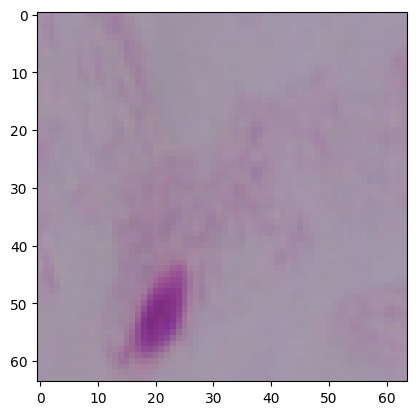

In [9]:
img,label=train_ds[10]
show_image(img,label)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        return len(self.dl)

In [11]:
device=get_default_device()
device

device(type='cuda')

In [12]:
batch_size=128
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size*2,num_workers=4,pin_memory=True)

train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)  
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        lr = result.get('lr', [0.0])
        train_loss = result.get('train_loss', 0.0)
        val_loss = result.get('val_loss', 0.0)
        val_acc = result.get('val_acc', 0.0)
        train_acc = result.get('train_acc', 0.0)  

        if isinstance(lr, list):
            lr = lr[-1]

        print(f"Epoch [{epoch}], "
              f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [14]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Parasite(ImageClassificationBase):
    
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.conv1=conv_block(in_channels,64)
        self.conv2=conv_block(64,128,pool=True)
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier=nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                     nn.Flatten(),
                                     nn.Dropout(0.2),
                                     nn.Linear(512,num_classes))
        
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []  
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)  
            train_losses.append(loss)
            train_accs.append(acc) 
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()  
        result['lr'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
            
    return history

In [16]:
model=to_device(Parasite(3,len(classes)),device)
model

Parasite(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [17]:
for batch in train_dl:
    images,labels=batch
    print('images.shape',images.shape)
    print('images.device',images.device)
    preds=model(images)
    print('preds.shape',preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 8])


In [18]:
history=evaluate(model,valid_dl)
history

{'val_loss': 2.0652928352355957, 'val_acc': 0.09957551956176758}

In [19]:
import time
history=[]
start=time.time()
history.extend(fit_one_cycle(5,0.001,model,train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.1,opt_func=torch.optim.Adam))

print(f'Total time: {(time.time()-start)/60} minutes')

Epoch [0], train_loss: 0.1665, train_acc: 0.9486, val_loss: 0.0946, val_acc: 0.9715
Epoch [1], train_loss: 0.0574, train_acc: 0.9829, val_loss: 0.0213, val_acc: 0.9934
Epoch [2], train_loss: 0.0225, train_acc: 0.9935, val_loss: 0.0139, val_acc: 0.9965
Epoch [3], train_loss: 0.0096, train_acc: 0.9973, val_loss: 0.0068, val_acc: 0.9977
Epoch [4], train_loss: 0.0050, train_acc: 0.9989, val_loss: 0.0067, val_acc: 0.9975
Total time: 4.281213541825612 minutes


In [20]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,classification_report
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_ds:
        inputs = inputs.to(device)
        inputs = torch.cat([inputs, inputs, inputs], dim=1)
        
        inputs = inputs.unsqueeze(0)
        labels = torch.tensor(labels, device=device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.append(labels.item())  

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

In [21]:
accuracy,f1,precision

(0.9973757107450065, 0.9938581436143228, 0.9941372464656598)

In [22]:
classification_report(all_labels,all_preds)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       229\n           1       1.00      0.99      1.00       550\n           2       0.99      1.00      0.99       288\n           3       0.97      0.97      0.97       177\n           4       1.00      1.00      1.00      1802\n           5       1.00      1.00      1.00      1305\n           6       1.00      1.00      1.00      2018\n           7       1.00      1.00      1.00       490\n\n    accuracy                           1.00      6859\n   macro avg       0.99      0.99      0.99      6859\nweighted avg       1.00      1.00      1.00      6859\n'

In [23]:
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

def predict(index, dataset, model, classes):
    img, label = dataset[index]
    show_image(img, label)
    pred = predict_image(img, model, classes)
    print('Predicted: ', pred)

Label:  Trichomonad (6)
Predicted:  Trichomonad


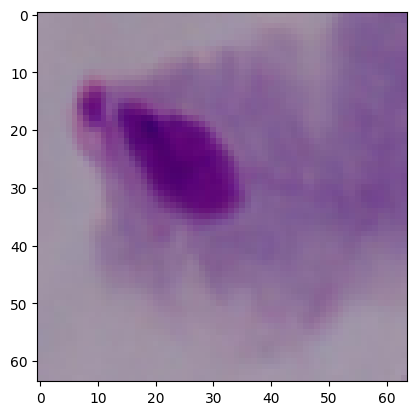

In [24]:
predict(10,valid_ds,model,classes)

Label:  RBCs (4)
Predicted:  RBCs


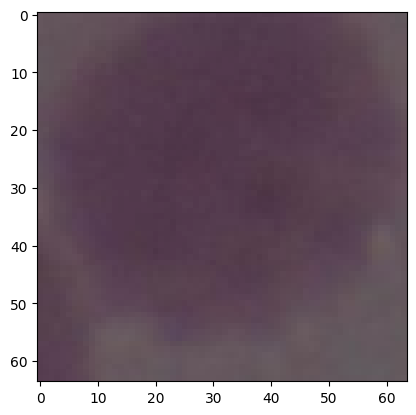

In [25]:
predict(1000,valid_ds,model,classes)

Label:  Leishmania (1)
Predicted:  Leishmania


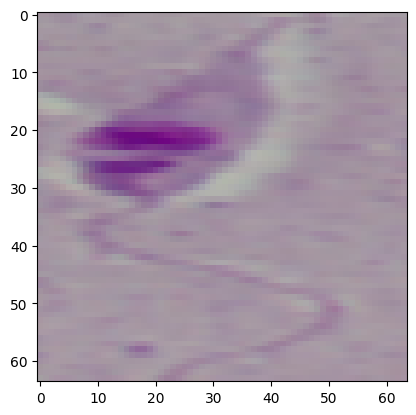

In [26]:
predict(100,valid_ds,model,classes)

Label:  RBCs (4)
Predicted:  RBCs


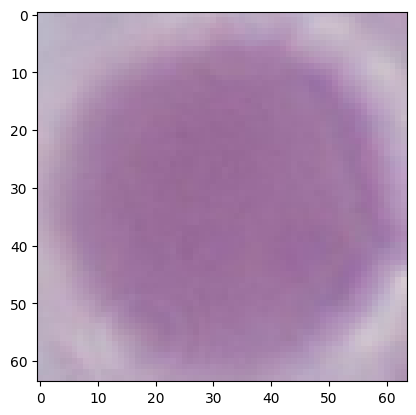

In [27]:
predict(2000,valid_ds,model,classes)

Label:  Toxoplasma (5)
Predicted:  Toxoplasma


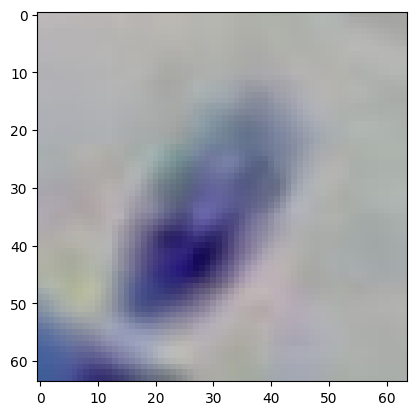

In [28]:
predict(4000,valid_ds,model,classes)

Label:  Toxoplasma (5)
Predicted:  Toxoplasma


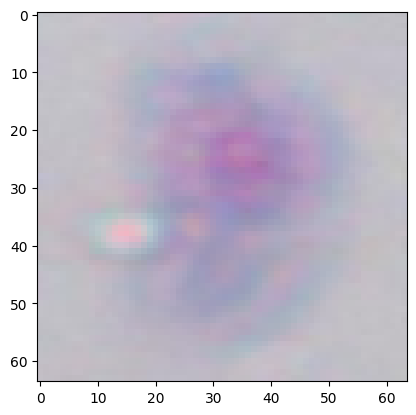

In [30]:
predict(5000,valid_ds,model,classes)

Label:  RBCs (4)
Predicted:  RBCs


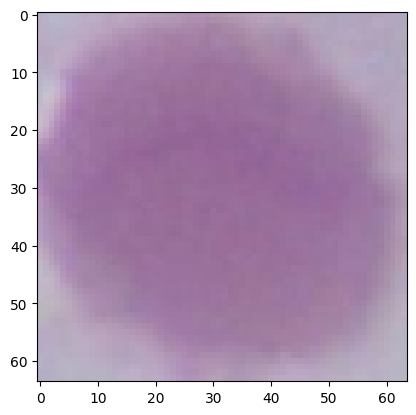

In [31]:
predict(6000,valid_ds,model,classes)